# Multi‑Knapsack, Multi‑Dimensional — Hill Climbing for 3 Variants



## Setup: instance generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

NUM_KNAPSACKS = 3
NUM_ITEMS = 16
NUM_DIMENSIONS = 2

VALUES = np.random.randint(10, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(5, 40, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(120, 200, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

print('VALUES:', VALUES)
print('WEIGHTS:\n', WEIGHTS)
print('CONSTRAINTS:\n', CONSTRAINTS)


VALUES: [61 24 81 70 30 92 96 84 84 97 33 12 31 62 11 97]
WEIGHTS:
 [[34  6]
 [25 37]
 [16 26]
 [29 31]
 [32 20]
 [19  7]
 [11 25]
 [13 22]
 [ 8 29]
 [18 13]
 [30  6]
 [24 32]
 [11 12]
 [39 18]
 [21  8]
 [ 6 10]]
CONSTRAINTS:
 [[173 123]
 [173 182]
 [137 163]]


## Common helpers

In [2]:
def usage_from_bool(assign_bool, weights):
    """Per‑knapsack usage for boolean assignment (K,N)."""
    K = assign_bool.shape[0]
    D = weights.shape[1]
    used = np.zeros((K, D), dtype=float)
    for k in range(K):
        if assign_bool[k].any():
            used[k] = weights[assign_bool[k]].sum(axis=0)
    return used

def feasible_bool(assign_bool, weights, constraints):
    if np.any(assign_bool.sum(axis=0) > 1):
        return False
    used = usage_from_bool(assign_bool, weights)
    return bool(np.all(used <= constraints + 1e-9))

def value_bool(assign_bool, values):
    return int((assign_bool * values).sum())

def feasible_fractional(frac_assign, weights, constraints):
    # per‑item total fraction ≤ 1
    if np.any(frac_assign.sum(axis=0) > 1 + 1e-9):
        return False
    # per‑knapsack per‑dimension usage
    used = (frac_assign[:, :, None] * weights[None, :, :]).sum(axis=1)
    return bool(np.all(used <= constraints + 1e-9))

def value_fractional(frac_assign, values):
    return float((frac_assign * values).sum())

def usage_from_counts(counts, weights):
    # counts: (K,N) int
    return (counts[:, :, None] * weights[None, :, :]).sum(axis=1)

def feasible_counts(counts, weights, constraints):
    return bool(np.all(usage_from_counts(counts, weights) <= constraints + 1e-9))

def value_counts(counts, values):
    return int((counts * values).sum())


## Variant 1: 0/1 multi‑knapsack — Hill Climbing

In [3]:
def random_bool_solution(K, N, p=0.35):
    sol = np.zeros((K, N), dtype=bool)
    for i in range(N):
        if np.random.random() < p:
            k = np.random.randint(0, K)
            sol[k, i] = True
    return sol

def repair_bool(sol, weights, constraints, values):
    # fix duplicates (keep knapsack with more residual space)
    K, N = sol.shape
    for i in range(N):
        ks = np.where(sol[:, i])[0]
        if ks.size > 1:
            best_k = None; best_margin = -1e18
            for k in ks:
                used_k = weights[sol[k]].sum(axis=0) if sol[k].any() else np.zeros(weights.shape[1])
                margin = (constraints[k] - used_k)
                score = margin.sum()
                if score > best_margin:
                    best_margin = score; best_k = k
            sol[ks, i] = False
            sol[best_k, i] = True
    # drop worst density items until capacity holds
    dens = values / (weights.sum(axis=1))
    for k in range(K):
        while True:
            if not sol[k].any(): break
            used = weights[sol[k]].sum(axis=0)
            if np.all(used <= constraints[k]): break
            idx = np.where(sol[k])[0]
            worst = idx[np.argmin(dens[idx])]
            sol[k, worst] = False
    return sol

def neighbor_bool_first_improve(sol, weights, constraints, values):
    K, N = sol.shape
    base = value_bool(sol, values)
    # try insertions
    unassigned = np.where(sol.sum(axis=0) == 0)[0]
    for i in unassigned[np.argsort(-values[unassigned])]:
        for k in range(K):
            used_k = weights[sol[k]].sum(axis=0) if sol[k].any() else np.zeros(weights.shape[1])
            if np.all(used_k + weights[i] <= constraints[k]):
                cand = sol.copy(); cand[k, i] = True
                val = value_bool(cand, values)
                if val > base: return cand
    # try moves
    for i in np.argsort(-values):
        src = np.where(sol[:, i])[0]
        if src.size == 0: continue
        k1 = int(src[0])
        for k2 in range(K):
            if k1 == k2: continue
            used_k2 = weights[sol[k2]].sum(axis=0) if sol[k2].any() else np.zeros(weights.shape[1])
            if np.all(used_k2 + weights[i] <= constraints[k2]):
                cand = sol.copy(); cand[k1, i] = False; cand[k2, i] = True
                val = value_bool(cand, values)
                if val > base: return cand
    # try swaps
    for k1 in range(K):
        items1 = np.where(sol[k1])[0]
        for k2 in range(k1+1, K):
            items2 = np.where(sol[k2])[0]
            for i in items1:
                for j in items2:
                    cand = sol.copy()
                    cand[k1, i] = False; cand[k2, j] = False
                    used1 = weights[cand[k1]].sum(axis=0) if cand[k1].any() else np.zeros(weights.shape[1])
                    used2 = weights[cand[k2]].sum(axis=0) if cand[k2].any() else np.zeros(weights.shape[1])
                    if np.all(used1 + weights[j] <= constraints[k1]) and np.all(used2 + weights[i] <= constraints[k2]):
                        cand[k1, j] = True; cand[k2, i] = True
                        val = value_bool(cand, values)
                        if val > base: return cand
    return None

def hc_bool(values, weights, constraints, max_iters=4000, restarts=4, p_start=0.35):
    K, N = constraints.shape[0], values.shape[0]
    best_sol, best_val = None, -1
    for _ in range(restarts):
        sol = random_bool_solution(K, N, p=p_start)
        sol = repair_bool(sol, weights, constraints, values)
        # climb
        it = 0
        while it < max_iters:
            it += 1
            neigh = neighbor_bool_first_improve(sol, weights, constraints, values)
            if neigh is None: break
            sol = neigh
        val = value_bool(sol, values)
        if val > best_val:
            best_val = val; best_sol = sol
    return best_sol, best_val

sol01, val01 = hc_bool(VALUES, WEIGHTS, CONSTRAINTS)
print('0/1 Hill Climbing total value:', val01)
print('0/1 items per knapsack:', [np.where(sol01[k])[0].tolist() for k in range(NUM_KNAPSACKS)])


0/1 Hill Climbing total value: 965
0/1 items per knapsack: [[0, 5, 6, 7, 8, 9, 13], [1, 2, 3, 10, 11, 12, 14], [4, 15]]


## Variant 2: Fractional multi‑knapsack — Hill Climbing on a discretized grid

In [4]:
def hc_fractional(values, weights, constraints, step=0.1, max_iters=6000):
    # frac_assign: (K,N) in [0,1], sum_k frac[k,i] ≤ 1
    K, N = constraints.shape[0], values.shape[0]
    frac = np.zeros((K, N), dtype=float)

    def feasible(fr):
        return feasible_fractional(fr, weights, constraints)

    def neighbors_first(fr):
        base = value_fractional(fr, values)
        # try add step to some (k,i)
        for i in np.argsort(-values):
            # capacity headroom per knapsack
            for k in range(K):
                if fr[:, i].sum() >= 1 - 1e-9:  # item fully assigned
                    continue
                # attempt +step
                add = min(step, 1 - fr[:, i].sum())
                if add <= 0: continue
                cand = fr.copy()
                cand[k, i] += add
                if not feasible(cand):
                    continue
                val = value_fractional(cand, values)
                if val > base: return cand
        # try move step from k1 to k2 for an item
        for i in np.argsort(-values):
            for k1 in range(K):
                if fr[k1, i] <= 1e-12: continue
                for k2 in range(K):
                    if k1 == k2: continue
                    move = min(step, fr[k1, i])
                    cand = fr.copy()
                    cand[k1, i] -= move
                    cand[k2, i] += move
                    if not feasible(cand):
                        continue
                    val = value_fractional(cand, values)
                    if val > value_fractional(fr, values):
                        return cand
        # try remove small step to free capacity for future moves (not improving step skipped here)
        return None

    it = 0
    while it < max_iters:
        it += 1
        neigh = neighbors_first(frac)
        if neigh is None:
            break
        frac = neigh

    return frac, value_fractional(frac, values)

solF, valF = hc_fractional(VALUES, WEIGHTS, CONSTRAINTS, step=0.1)
print('Fractional HC total value:', round(valF, 2))
print('Fractional non‑zero entries (k: [(i, frac), ...]):',
      [{k: [(int(i), float(solF[k,i])) for i in np.where(solF[k]>1e-9)[0]]} for k in range(NUM_KNAPSACKS)])


Fractional HC total value: 965.0
Fractional non‑zero entries (k: [(i, frac), ...]): [{0: [(0, 0.2), (2, 0.6), (5, 0.9999999999999999), (6, 0.8999999999999999), (7, 0.9999999999999999), (8, 0.9999999999999999), (9, 0.9999999999999999), (15, 0.9999999999999999)]}, {1: [(0, 0.7999999999999999), (2, 0.4), (3, 0.9999999999999999), (4, 0.8999999999999999), (6, 0.1), (10, 0.9999999999999999), (12, 0.9999999999999999), (13, 0.9999999999999999)]}, {2: [(1, 0.9999999999999999), (4, 0.1), (11, 0.9999999999999999), (14, 0.9999999999999999)]}]


## Variant 3: Unbounded multi‑knapsack — Hill Climbing over integer counts

In [5]:
def hc_unbounded(values, weights, constraints, max_iters=8000):
    K, N = constraints.shape[0], values.shape[0]
    counts = np.zeros((K, N), dtype=int)

    def neighbors_first(cnt):
        base = value_counts(cnt, values)
        # try increments
        for i in np.argsort(-values):
            for k in range(K):
                cand = cnt.copy(); cand[k, i] += 1
                if feasible_counts(cand, weights, constraints):
                    val = value_counts(cand, values)
                    if val > base: return cand
        # try swaps: remove one of low value, add one of high value
        order_low = np.argsort(values)
        order_high = np.argsort(-values)
        for k in range(K):
            for i in order_low:
                if cnt[k, i] <= 0: continue
                for j in order_high:
                    if j == i: continue
                    cand = cnt.copy()
                    cand[k, i] -= 1
                    cand[k, j] += 1
                    if feasible_counts(cand, weights, constraints):
                        val = value_counts(cand, values)
                        if val > base: return cand
        return None

    it = 0
    while it < max_iters:
        it += 1
        neigh = neighbors_first(counts)
        if neigh is None:
            break
        counts = neigh

    return counts, value_counts(counts, values)

solU, valU = hc_unbounded(VALUES, WEIGHTS, CONSTRAINTS)
print('Unbounded HC total value:', valU)
print('Unbounded non‑zero counts per knapsack:',
      [dict((int(i), int(c)) for i, c in enumerate(solU[k]) if c>0) for k in range(NUM_KNAPSACKS)])


Unbounded HC total value: 4462
Unbounded non‑zero counts per knapsack: [{15: 12}, {15: 18}, {15: 16}]


## Results & Comparison Plot

==== SUMMARY ====
0/1 HC value:       965
Fractional HC value:965.00
Unbounded HC value: 4462


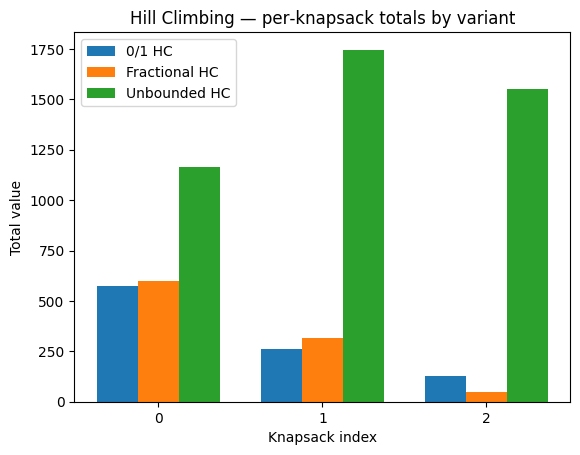

In [6]:
print('==== SUMMARY ====')
print(f'0/1 HC value:       {val01}')
print(f'Fractional HC value:{valF:.2f}')
print(f'Unbounded HC value: {valU}')

vals01 = (sol01 * VALUES).sum(axis=1)
valsF  = (solF  * VALUES).sum(axis=1)
valsU  = (solU  * VALUES).sum(axis=1)

import numpy as np
x = np.arange(NUM_KNAPSACKS)
width = 0.25
plt.figure()
plt.bar(x - width, vals01, width, label='0/1 HC')
plt.bar(x,          valsF,  width, label='Fractional HC')
plt.bar(x + width,  valsU,  width, label='Unbounded HC')
plt.xticks(x)
plt.xlabel('Knapsack index')
plt.ylabel('Total value')
plt.title('Hill Climbing — per‑knapsack totals by variant')
plt.legend()
plt.show()
